In [27]:
using Oceananigans

In [28]:
using Oceananigans.Units
using Oceananigans.Models.HydrostaticFreeSurfaceModels: ImplicitFreeSurface

In [38]:
grid=RectilinearGrid(size=(128,1),x=(0,1000kilometers),z=(-400meters,0),topology=(Bounded,Flat,Bounded))

RectilinearGrid{Float64, Bounded, Flat, Bounded}
             architecture: CPU()
                   domain: x ∈ [0.0, 1.0e6], y ∈ [1.0, 1.0], z ∈ [-400.0, 0.0]
                 topology: (Bounded, Flat, Bounded)
        size (Nx, Ny, Nz): (128, 1, 1)
        halo (Hx, Hy, Hz): (1, 0, 1)
             spacing in x: Regular, with spacing 7812.5
             spacing in y: Flattened
             spacing in z: Regular, with spacing 400.0

In [39]:
coriolis=FPlane(f=1e-4)
model=HydrostaticFreeSurfaceModel(grid=grid,coriolis=coriolis,free_surface=ImplicitFreeSurface())

HydrostaticFreeSurfaceModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RectilinearGrid{Float64, Bounded, Flat, Bounded}(Nx=128, Ny=1, Nz=1)
├── tracers: (:T, :S)
├── closure: Nothing
├── buoyancy: Buoyancy{SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}, Oceananigans.Grids.ZDirection}
└── coriolis: FPlane{Float64}

In [43]:
gaussian(x,L)=exp(-x^2/2L^2)
U=0.1
L=grid.Lx/40
x_o=grid.Lx/4
V_g(x,y,z)=-U*(x-x_o)/L*gaussian(x-x_o,L)
g=model.free_surface.gravitational_acceleration
n_o=coriolis.f*U*L/g
n_g(x)=n_o*gaussian(x-x_o,L)

n_g (generic function with 1 method)

In [44]:
n_i(x,y)=2*n_g(x)

n_i (generic function with 1 method)

In [45]:
set!(model,v=V_g,η=n_i)

In [46]:
gravity_wave_speed = sqrt(g * grid.Lz)

wave_propagation_time_scale = model.grid.Δxᶜᵃᵃ / gravity_wave_speed

simulation = Simulation(model, Δt = 0.1wave_propagation_time_scale, stop_iteration = 1000)

Simulation{typename(HydrostaticFreeSurfaceModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0
├── Next time step: 12.474 seconds
├── Elapsed wall time: 0 seconds
├── Stop time: Inf years
├── Stop iteration : 1000.0
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [47]:
output_fields = merge(model.velocities, (η=model.free_surface.η,))

simulation.output_writers[:fields] = JLD2OutputWriter(model, output_fields,
                                                      schedule = IterationInterval(10),
                                                      prefix = "geostrophic_adjustment",
                                                      field_slicer = nothing,
                                                      force = true)

run!(simulation)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (30.767 ms)
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:190
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (15.913 ms).
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model iteration 1000 has hit or exceeded simulation stop iteration 1000.
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\simulation.jl:155


In [48]:
using Oceananigans.OutputReaders: FieldTimeSeries
using Plots, Printf

u_timeseries = FieldTimeSeries("geostrophic_adjustment.jld2", "u")
v_timeseries = FieldTimeSeries("geostrophic_adjustment.jld2", "v")
η_timeseries = FieldTimeSeries("geostrophic_adjustment.jld2", "η")

xη = xw = xv = xnodes(v_timeseries)
xu = xnodes(u_timeseries)

t = u_timeseries.times

anim = @animate for i = 1:length(t)

    u = interior(u_timeseries[i])[:, 1, 1]
    v = interior(v_timeseries[i])[:, 1, 1]
    η = interior(η_timeseries[i])[:, 1, 1]

    titlestr = @sprintf("Geostrophic adjustment at t = %.1f hours", t[i] / hours)

    u_plot = plot(xu / kilometers, u, linewidth = 2,
                  label = "", xlabel = "x (km)", ylabel = "u (m s⁻¹)", ylims = (-2e-3, 2e-3))

    v_plot = plot(xv / kilometers, v, linewidth = 2, title = titlestr,
                  label = "", xlabel = "x (km)", ylabel = "v (m s⁻¹)", ylims = (-U, U))

    η_plot = plot(xη / kilometers, η, linewidth = 2,
                  label = "", xlabel = "x (km)", ylabel = "η (m)", ylims = (-n_o/10, 2n_o))

    plot(v_plot, u_plot, η_plot, layout = (3, 1), size = (800, 600))
end

Animation("C:\\Users\\shiva\\AppData\\Local\\Temp\\jl_HCynBo", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png", "000101.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\anim_fps60_exp.gif
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\anim_fps60_exp.gif")
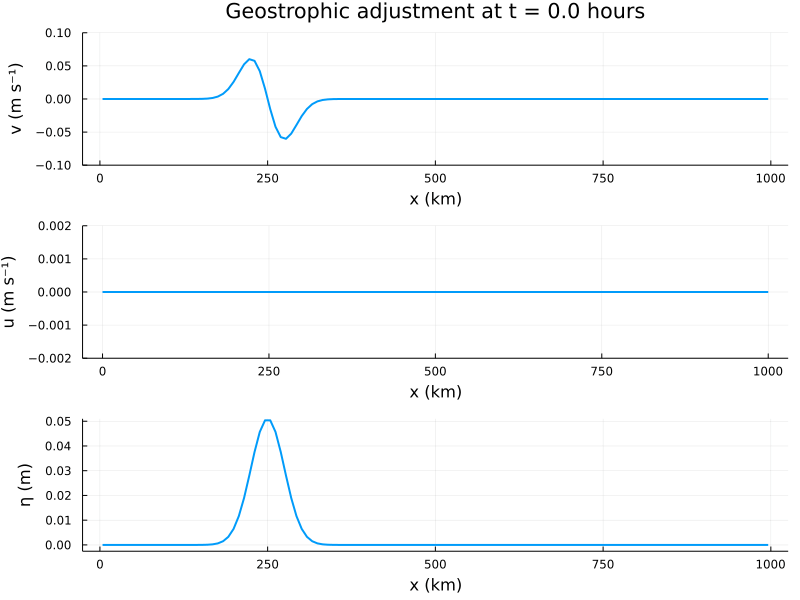

In [49]:
gif(anim, "anim_fps60_exp.gif", fps = 60)